In [1254]:
import importlib
import numpy
from scripts import NN
import math as m
from scripts import io
importlib.reload(NN)
importlib.reload(io)
import random as rand
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd

## These chunks implement the auto encoder

### Part 1


In [914]:
#this instantiates the auto encoder
setup = [8,3,8] #the network architecture [input,hidden,output]
alpha = 0.5 #the learning rate
lamba = 0 #weight decay is not used for autoencoder
auto_NN = NN.NeuralNetwork(setup,NN.activation,alpha,lamba) #initialize the auto encoder

In [915]:
#this trains the auto_encoder
epoch_number = 100000
cost_list = []
input_size   = 8
#this training regime updates the weights after each training example. It trains on an 8-element vector where each time a random single bit is flipped
for j in range(epoch_number):
    training_batch = numpy.zeros((input_size)) #first make an empty vector
    rand_index = int(numpy.ceil(rand.random()*8)-1) #get a random 0 to 7 index
    training_batch[rand_index] = 1 #flip the bit at that random index
    training_batch = [training_batch] #not very clean but training expects a list of training examples
    training_answer = training_batch #auto encoder uses the input as the "answer"
    auto_NN.get_training_set(training_batch,training_answer) #import the training example and answer
    cost_list.append(auto_NN.batch_descent()) #update the weights using gradient descent

In [916]:
#this chunk displays that the autoencoder has the correct behavior
print("the prediction for [1,0,0,0,0,0,0,0] is", auto_NN.predict([1,0,0,0,0,0,0,0]))
print("the prediction for [0,1,0,0,0,0,0,0] is", auto_NN.predict([0,1,0,0,0,0,0,0]))
print("the prediction for [0,0,1,0,0,0,0,0] is", auto_NN.predict([0,0,1,0,0,0,0,0]))
print("the prediction for [0,0,0,1,0,0,0,0] is", auto_NN.predict([0,0,0,1,0,0,0,0]))
print("the prediction for [0,0,0,0,1,0,0,0] is", auto_NN.predict([0,0,0,0,1,0,0,0]))
print("the prediction for [0,0,0,0,0,1,0,0] is", auto_NN.predict([0,0,0,0,0,1,0,0]))
print("the prediction for [0,0,0,0,0,0,1,0] is", auto_NN.predict([0,0,0,0,0,0,1,0]))
print("the prediction for [0,0,0,0,0,0,0,1] is", auto_NN.predict([0,0,0,0,0,0,0,1]))

the prediction for [1,0,0,0,0,0,0,0] is [9.72778216e-01 4.92914000e-05 2.51978563e-02 3.44102102e-06
 1.28572793e-02 4.97671349e-10 2.97083137e-06 1.19855777e-02]
the prediction for [0,1,0,0,0,0,0,0] is [1.10142246e-04 9.72255134e-01 1.60163923e-07 1.63983221e-05
 1.69157340e-02 2.21088430e-02 2.17687709e-05 1.65190834e-02]
the prediction for [0,0,1,0,0,0,0,0] is [4.85190459e-03 7.57594499e-10 9.62262412e-01 1.41031262e-02
 5.36658985e-06 4.75595904e-07 1.33346002e-02 1.75712173e-06]
the prediction for [0,0,0,1,0,0,0,0] is [3.71739265e-06 2.47150365e-06 2.32674176e-02 9.71941596e-01
 1.94710845e-09 1.39841389e-02 4.58878365e-05 1.63420368e-02]
the prediction for [0,0,0,0,1,0,0,0] is [2.29351709e-02 1.53264185e-02 9.76345794e-05 1.04971347e-08
 9.75479166e-01 6.17618268e-06 1.95235293e-02 6.17677055e-07]
the prediction for [0,0,0,0,0,1,0,0] is [2.15010256e-08 1.37945662e-02 1.48004695e-05 2.19034727e-02
 2.25884703e-05 9.72248584e-01 2.15979137e-02 1.56426862e-05]
the prediction for [0,

Text(0.5, 1.0, 'Cost at Each Output Node per Epoch In the Autoencoder')

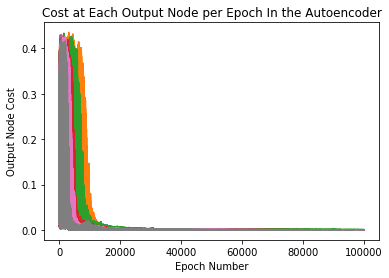

In [919]:
#plot the cost after each training iteration
plt.plot(cost_list)
plt.xlabel('Epoch Number')
plt.ylabel('Output Node Cost')
plt.title('Cost at Each Output Node per Epoch In the Autoencoder')

## Part 2 
## these chunks implement classification of rap1 sequences

### Question 2
My implementation encodes the DNA sequences using the function 'one_hot_encode' in the io.py file. My implementation does this one hot encoding in a very vanilla way. For a given k-mer, it creates a 4*k length vector where each indices 0 to 3 refer to position 0 in the k-mer, indices 4 to 7 refer to position 1 in the k-mer, etc. Within each of these sets of 4, position 0 is flipped if the k-mer position is A, 1 for T, 2 for G, 3 for C. This method basically makes the assumption that primary sequence is the only thing that matters and that each nucleotide has unique interaction with the protein. For example this method would not easily exchange purine bases. It also assumes that each sequence is in the same 'frame', if the motif were to appear in the proper order but later in the 17-mer this encoding would not capture that. In theory, a convolutional approach could account for this or expanding the encoding to shift the k-mer about. This second approach would make the input vector much larger and would add computational time. It would possibly also require more training for the model to converge. Given the results below and a visual inspection of the positive examples, they appear to be in the same frame. A final note of the implications of this, is that it is not necessarily forgiving of sequencer errors. While those should be rare, this strict encoding will penalize those.

### Question 3
The following 2 chunks illustrate the general training scheme for the rap1 binding sites. The essential data preparation steps are contained in the scripts in the io.py, specifically these are 'import_positives', 'import_negatives', and 'shuffle_concat'. Import positives is very simple in that it expects a text file where each line is a k-mer and returns a list of those k-mers in ATCG encoding. Import negatives is slightly more complex in that it expects the 1000 bp of upstream genomic information and begins to reduce that information. In essence what it does is it find the start of each gene, it then selects a random row and starting index within that row to retrieve a k-mer. Ihe k-mer length is given by the user. It then returns a list of one of these randomly selected k-mers for each gene. I always call this function with the full 17 k-mer length, as I train on the full length k-mer. The next important step is contained within io.shuffle_concat. With this function I consider how to balance the positive to the negative examples. This is done using the passed integer parameter, which indicates how many fold more negative examples to include in the training set compared to the positive set. Below, I have chosen 3, so for every positive 17-mer given I will include 3 randomly selected negative 17-mers from the given positive and negative lists. This function is also useful in that it creates a paired answer list to provide for training the network and shuffles training examples so as the network is trained on small batches stepping through the training list in order it sees both positive and negative examples and no given example twice in the same epoch. For this step all k-mers are still in ATCG encoding. In the below training I have chosen 3 fold more negative examples, because I felt it cut down on the overweighting of negative data while also allowing the network to explore more of the larger negative space. One bullet in the assignment this does not address is the possibility for the negative set to contain positive motifs. However, if we assume transcription factors generally recognize short motifs in the ~5 bp range. Then there is a 1 in 1024 chance to select an exact 5-mer from a random list of 5-mers. My procedure is likely to be roughly analogous to this given the randomness in choosing k-mers. With a 3-fold larger negative set than positive set, I would expect less than 1 negative example per training set to match a positive site by chance. I don't expect 1 mis-labelled example to distrupt training to a large degree. 

The final bit of my training paradigm is actually contained in the 'train' function within the NeuralNetwork class. This is where the epoch number and batch size are set by the user. To use this function those parameters along with a paired training example list and answer list must be provided. The training list should be in ATCG encoding. This function then trains the neural network by first switching the encoding to the one hot encoding discribed above, it then does feedforward and backprop for the number of examples given in batch size before updating the weights. It does this until it has worked through the entire provided training list, this is 1 epoch. It repeats this process as many times as indicated by the epoch_number parameter. The updated weights are contained within the NeuralNetwork object and will automatically be used for prediction. Training also returns the cost per batch of samples trained.

### Question 4

In [1255]:
setup = [68,20,10,1] #network architechture 2 hidden layers trying to reduce the size of the previous layer by 1/2 to 1/3 each time
alpha = 0.2 #learning rate
lamba = 0 #no weight decay here, preliminary results show this makes convergence much more difficult
rap1_NN = NN.NeuralNetwork(setup,NN.activation,alpha,lamba) #initialize the network

In [1256]:
rap1_pos_list = io.import_positives('data/rap1-lieb-positives.txt') #get the list of positive 17-mers
genom_neg_list = io.import_negatives('data/yeast-upstream-1k-negative.fa',17) #get a list of randomly selected negative 17-mers 1 per gene
rap1_test_list = io.import_positives('data/rap1-lieb-test.txt')# get the list of 17-mers to test

In [1257]:
epoch_number = 1000 # the number of times through the whole data set
batch_size = 20 #number of examples to train on per batch
shuffle_train_list, shuffle_answer_list = io.shuffle_concat(rap1_pos_list,genom_neg_list,3) #one hot encode training examples and shuffle the positive and 
#negative examples all into a single list


cost_list = rap1_NN.train(epoch_number,batch_size,shuffle_train_list,shuffle_answer_list) #train the network and keep track of cost

Text(0.5, 1.0, 'Cost per Mini-Training Batch')

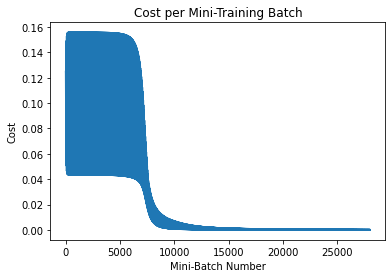

In [1258]:
#plot the cost per batch of training examples provided
plt.plot(cost_list)
plt.xlabel('Mini-Batch Number')
plt.ylabel('Cost')
plt.title('Cost per Mini-Training Batch')

The chunks below answer question 4 part a. The plot above answers question 4 part b/c. The network architecture I chose was to have two hidden layers and a single out put layer. With the hidden layers I wanted to approximately halve the preceeding layer in terms of numbers of nodes. This actually does quite well. In terms of reducing cost/error the network has a pretty interesting behavior. I would describe the plot above like there are 3 regimes: no movement, rapid convergence, and refinement. The plot above has sections taht look almost solid, but that is due to the cost flucuating up and down with resolution not acheivable by the plot. I bascially chose a number of epochs to perform by selecting a number in which the cost has past the precipitous drop observed around 6000 minibatch. It is interesting in playing around with the epoch number a choice near but before convergance has basically 0 predictive power. Additionally, a choie after the large drop is extremely accurate as seen below in the k-fold validation. All in all it looks like with these parameteres the network performs quite well and as expected. In theory it could be memorizing answer, but that will be emperically tested below. 

In [1259]:
#check a single positive input as sanity
pos_test = io.one_hot_encode([rap1_pos_list[100]])
pos_test = pos_test[0]
print("The ATCG encoding of the positive test is ",rap1_pos_list[100])
print("The one hot encoding of the positive test is ",pos_test)
print("Prediction of positive test is ",rap1_NN.predict(pos_test))

The ATCG encoding of the positive test is  GAACCCAAACATTATAG
The one hot encoding of the positive test is  [0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
Prediction of positive test is  [0.92516282]


In [1260]:
#check a single negative input as sanity
neg_test = io.one_hot_encode([genom_neg_list[100]])
neg_test = neg_test[0]
print("The ATCG encoding of the positive test is ",genom_neg_list[100])
print("The one hot encoding of the positive test is ",neg_test)
print("Prediction of negative test is ", rap1_NN.predict(neg_test))

The ATCG encoding of the positive test is  AGAGCCTCTTCATTCCT
The one hot encoding of the positive test is  [1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
Prediction of negative test is  [0.00442117]


## These chunks implement k-fold cross validation

## Part 3
### question 5

To validate the above network, k-fold validation is very useful. In this validation, I will break the training set into k-chunks. I will validate the network k-times by each time selecting a chunk to be the validation set. I will then train the network on all the other sets. After this training I will use the validation set to create a ROC curve. For each validation I will calculate the auROC as a measure of the performance. This will result in k auROCs which I can average to give a sense how well the network validated on the whole. Functionally this is implemented by processing the training sets just as above. However, k-fold validation is actually handled by 'k_fold_validation' a function in NN.py. This function takes the shuffled training list and splits it into k-chunks. It the does the above descirbed validation. It then returns two nested lists of True Positive Rates and False Positive Rates for each validation iteration. These can then be plotted and the auROC can be determined using the 'roc_auc_list' function in NN.py. In the 'literature' a default value for k is often chosen to be 10. For this particular use case, however, that seemd to me innappropriate. That would mean a single chunk would only contain 14 positive examples, which is not that statistically powerful. Instead, I have chosen to use a k of 4. I felt that this provided the chance to multiple validations per training set, but retain a decently sized number of positive examples in both the training and validation chunks. I did test it with k=10 and the results are very similar to k=4. Only k=4 has been kept here, due to the preceding reasoning.

In [1261]:
#instantiate the neural network using the same parameters as above
setup = [68,20,10,1]
alpha = 0.2
lamba = 0 
batch_size = 20
epoch_number = 1000
k = 4

In [1262]:
rap1_pos_list = io.import_positives('data/rap1-lieb-positives.txt') #as before get the positive examples, not needed here but for clarity it is kept
genom_neg_list = io.import_negatives('data/yeast-upstream-1k-negative.fa',17)#as before get the negative examples, not needed here but for clarity it is kept

In [1263]:
shuffle_train_list, shuffle_answer_list = io.shuffle_concat(rap1_pos_list,genom_neg_list,3)#as before shuffle and reduce negative examples,
#not needed here but for clarity it is kept

In [1264]:
 roc_FPRs, roc_TPRs  = NN.k_fold_validation(shuffle_train_list,shuffle_answer_list,epoch_number,batch_number,setup,alpha,lamba,k) #perform the validation

Text(0.5, 1.0, 'ROC Curve for the First Validation Iteration')

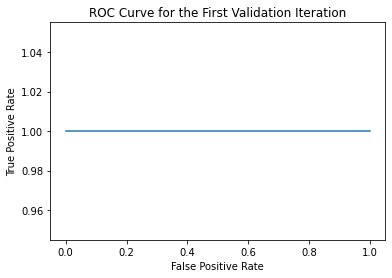

In [1265]:
plt.plot(roc_FPRs[0],roc_TPRs[0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the First Validation Iteration')

Text(0.5, 1.0, 'ROC Curve for the Second Validation Iteration')

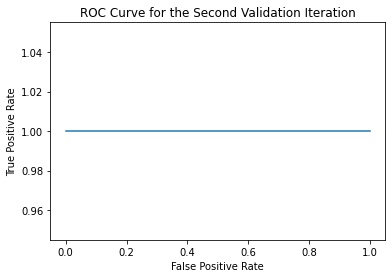

In [1266]:
plt.plot(roc_FPRs[1],roc_TPRs[1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Second Validation Iteration')

Text(0.5, 1.0, 'ROC Curve for the Third Validation Iteration')

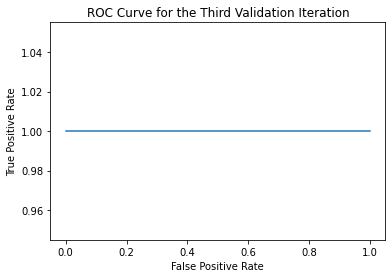

In [1267]:
plt.plot(roc_FPRs[2],roc_TPRs[2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Third Validation Iteration')

Text(0.5, 1.0, 'ROC Curve for the Fourth Validation Iteration')

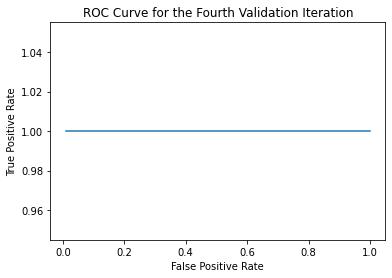

In [1268]:
plt.plot(roc_FPRs[3],roc_TPRs[3])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Fourth Validation Iteration')

In [1269]:
roc_AUCs = NN.roc_auc_list(roc_TPRs,roc_FPRs)
print("For K-fold validation the average auROC is ", numpy.mean(roc_AUCs))

For K-fold validation the average auROC is  0.9976415094339622


### part c written
I would say the model under these parameters performs remarkably well. The average auROC for 1 indicates that it can perfectly distinguish every single validation set example. I was shocked when I first saw this, and didn't quite believe it. But in checking everything this seems to be truly the case. I guess we can pack up and go home lol. In all reality, I guess what this means is that the previous strong performance is not likely to be a case of memorizing a given example. Further, model optimization at this point won't be about making the performance on the validation set better, but rather about making the model more effecient.

## Part 4
In this section I will implement a tournament style genetic algorithm to optimize the model. As I mentioned above I had already found parameters that very performed with very high accuracy. So in implementing this algorithm, I had two goals: 1st find the most 'efficient' paramters, particularly in terms of how large of batch sizes to use and how many epochs to perform, and 2nd to see if a weight decay parameter can be used in a productive way as most of the time in playing with the model above any value of lambda caused the network to fail to converge. To do this, I created my starting population with a set of parameters centered near the very edge of converge of the model above. This I hoped would find which parameters are most important from escaping that edge. So within this scheme I set out to otimize the size of each hidden layer (maintaining only 2 hidden layers), the learning rate, the weight decay constant, the number of epochs, and the batchsize. 

The actual optimization is done as mentioned above by a tournament style genetic algorithm contained in the function genetic_optimization within NN.py. To use this function the user must give a training list containing both positive and negative examples with the matching answer list. Further, it must provide a centers vector, the number of 0 generation population members to create, and the number of evolutions/generations to iterate through. The inital population uses the centers vector to create individual models with paramteres drawn from gaussian distributions centered at the value give in the centers vector. The standard deviation of this is quite large to explore a lot of parameter space (2X the mean given value). Once all the population members are created they are scored by finding the mean auROC from k-fold cross validation with k=2. An evolution is done by selecting 2 sets of two individuals with replacement (but a given set can't be identical) from the population and the one within each set that has a higher score is kept. These are the two parents. From there cross over can happen between the two parents at the fraction likelihood indicated by the user defined cross_rate (e.g. cross_rate = 0.2 a 20% any given parameter is swapped between parentes). Finally, the crossed over models can experience mutation at a rate indicated mutation_rate (e.g. mutation_rate = 0.05 a 5% chance any given parameter is mutated). I defined a mutation as a 15% increase or decrease in the parameter. The direction is randomly chosen with a equal probability of increase or decrease. This process as described to this point has created two children. For a generation this process is repeated drawing from the previous generation until the new population size = pop_num. This is performed for the given number of generations. 

In [710]:
#initialize the centers which will be used to creat generation 0
centers = [20,10,0.15,0.0000001,150,20] #see documentation/NN.py for which parameter corresponds to which parameter in centers

In [714]:
#I wanted to explore a large parameter space in a reasonable time. Since, each generation doesnt not explore as much new space as having more individuals 
#population size was prioritized over number of generations
generation_num = 20
pop_num = 100
cross_rate = 0.2
mutation_rate = 0.05

In [715]:
#standard data import and processing
rap1_pos_list = io.import_positives('data/rap1-lieb-positives.txt')
genom_neg_list = io.import_negatives('data/yeast-upstream-1k-negative.fa',17)
rap1_test_list = io.import_positives('data/rap1-lieb-test.txt')
shuffle_train_list, shuffle_answer_list = io.shuffle_concat(rap1_pos_list,genom_neg_list,3)

In [716]:
#run the optimization
best_individual, final_avg_score, final_max_score, generations = NN.genetic_optimization(shuffle_train_list,shuffle_answer_list,generation_num,pop_num,cross_rate,mutation_rate, centers)

1 evolutions have been performed
2 evolutions have been performed
3 evolutions have been performed
4 evolutions have been performed
5 evolutions have been performed
6 evolutions have been performed
7 evolutions have been performed
8 evolutions have been performed
9 evolutions have been performed
10 evolutions have been performed
11 evolutions have been performed
12 evolutions have been performed
13 evolutions have been performed
14 evolutions have been performed
15 evolutions have been performed
16 evolutions have been performed
17 evolutions have been performed
18 evolutions have been performed
19 evolutions have been performed
The generation scores are [[0.9974874371859297, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.7137096774193549, 0.5, 0.9974874371859297, 0.5, 0.5, 0.5, 0.5, 0.7379032258064516, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9987437185929647, 0.5, 0.5, 0.5, 0.5, 0.5, 0.999

Text(0.5, 1.0, 'The Average Score Over the Course of Evolution')

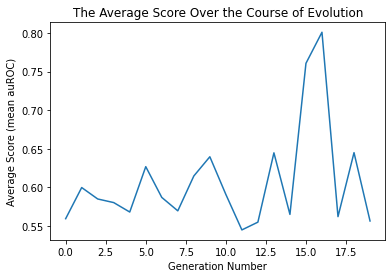

In [1122]:
plt.plot(final_avg_score)
plt.xlabel('Generation Number')
plt.ylabel('Average Score (mean auROC)')
plt.title('The Average Score Over the Course of Evolution')

Text(0.5, 1.0, 'The Maximum Score within a Generation Over Evolution')

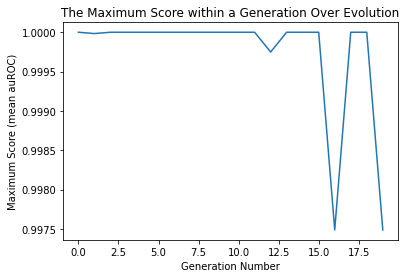

In [1123]:
plt.plot(final_max_score)
plt.xlabel('Generation Number')
plt.ylabel('Maximum Score (mean auROC)')
plt.title('The Maximum Score within a Generation Over Evolution')

In [1124]:
ind = best_individual
print('The best individual from the final generation has the following parameters:')
print('Number hidden layer 1 nodes: ',ind[0])
print('Number hidden layer 2 nodes: ',ind[1])
print('Learning rate: ',ind[2])
print('Weight Decay Lambda: ',ind[3])
print('Batch Size: ', ind[5])
print('Epoch Number: ', ind[4])

The best individual from the final generation has the following parameters:
Number hidden layer 1 nodes:  26
Number hidden layer 2 nodes:  1
Learning rate:  0.3860629823003823
Weight Decay Lambda:  1.2399863529660664e-07
Batch Size:  1
Epoch Number:  37


In [1172]:
ind = generations[0][0]
print('A similarly good individual from a preceeding generations has the following parameters:')
print('Number hidden layer 1 nodes: ',ind[0])
print('Number hidden layer 2 nodes: ',ind[1])
print('Learning rate: ',ind[2])
print('Weight Decay Lambda: ',ind[3])
print('Batch Size: ', ind[5])
print('Epoch Number: ', ind[4])

A similarly good individual from a preceeding generations has the following parameters:
Number hidden layer 1 nodes:  9
Number hidden layer 2 nodes:  3
Learning rate:  0.5323378601632274
Weight Decay Lambda:  1.3445221678474684e-07
Batch Size:  37
Epoch Number:  238


In [1173]:
#validate winner from above
#instantiate the neural network
winner = best_individual
setup = [68,winner[0],winner[1],1]
alpha = winner[2]
lamba = winner[3] #0.1 is good
batch_size = winner[5]
epoch_number = winner[4]
k = 4

In [1174]:
#standard data import and processing
rap1_pos_list = io.import_positives('data/rap1-lieb-positives.txt')
genom_neg_list = io.import_negatives('data/yeast-upstream-1k-negative.fa',17)
rap1_test_list = io.import_positives('data/rap1-lieb-test.txt')
shuffle_train_list, shuffle_answer_list = io.shuffle_concat(rap1_pos_list,genom_neg_list,3)

Text(0.5, 1.0, 'Example ROC Curve from K-Fold Validation of the Best Individual from Evolution')

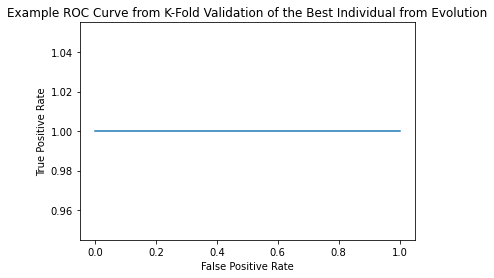

In [1176]:
#run K-fold validation
roc_FPRs, roc_TPRs  = NN.k_fold_validation(shuffle_train_list,shuffle_answer_list,epoch_number,batch_size,setup,alpha,lamba,k)
plt.plot(roc_FPRs[1],roc_TPRs[1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Example ROC Curve from K-Fold Validation of the Best Individual from Evolution')

In [1178]:
print("k-Fold Validation average auROC from the best individual: ", numpy.mean(NN.roc_auc_list(roc_TPRs,roc_FPRs)))

k-Fold Validation average auROC from the best individual:  1.0


### part 4 discussion
This exercise was really interesting to observe the behavior. In general the model seems to really have quite an all or nothing behavior. The scores from the various models created tend to either be 0.5 or nearly 1, with very few falling in the middle. Further, I would say the model as I tried to optimize above is 'fragile' with 1 or more parameters potentially able to break the convergence. I say this from intuition in playing with the models and the combindation of average and max generation score over time. I found it very interesting that nearly every generation had an individual with near 1 auROC. Further, generation scores on average did not display a clear trend over evolution. Two generations towards then end had quite high scores, but those actually fell in the final generations. This suggests to me that mutations and crossovers did not tend to find the best of given parents but these changes were highly likely to be detrimental. I would guess the parameters most likely to cause this would be not enough training epochs or too high a lambda value. As these were parameters I played with that had a large impact on perforamce. To a degree this is supported in the two example models from this above. In both cases the lambda value has remained extremely low. This could also have to do with how I tested performance. An alternate scheme I considered would have used the minimum number of epochs to reach convergence as the score. However, this could be quite time consuming if some models never converged and I wanted to find a very quick efficient model. 

In the end, I was suprised by the actual parameters of the best_individual. First it only performs 37 epochs, but has a batch size of 1. This is useful to know, in that for these data updating weights after each example allows for less examples to be trained on. The other model shown above has a batch size of 37 and 238 epochs meaning it must evaluate many more training examples to get a similar performance. The second parameter of best individual that surprised me was the 2nd hidden layer node number. It was reduced to 1, essentially eliminating that layer. I think this speaks to sort of the simplicity of this task from a NN standpoint, and despite the fact that this excercise broke more models than it created useful ones, I am quite happy it found a very efficient network.

If I had time to go further with this, I would perhaps abandon trying to optimize lambda and see if it would create more stable networks with which evolution could actually do some good. Also, experimenting with different activation functions could be quite interesting to see if the same things hold true about network size, etc.

## These chunks take the "best" network and classify the test set
I will use the best individual from the genetic algorithm above. I find it a kind of funny model in that the batch size is 1, only does 37 epochs, and is shallower than my original network.

In [1274]:
#model creation
winner = best_individual
setup = [68,winner[0],winner[1],1]
alpha = winner[2]
lamba = winner[3] #0.1 is good
batch_size = winner[5]
epoch_number = winner[4]

In [1275]:
#process all the data
rap1_pos_list = io.import_positives('data/rap1-lieb-positives.txt')
genom_neg_list = io.import_negatives('data/yeast-upstream-1k-negative.fa',17)
rap1_test_list = io.import_positives('data/rap1-lieb-test.txt')
shuffle_train_list, shuffle_answer_list = io.shuffle_concat(rap1_pos_list,genom_neg_list,5)

In [1276]:
#create model
final_rap1 = NN.NeuralNetwork(setup,NN.activation,alpha,lamba)

In [1277]:
#train on all data
cost_list = final_rap1.train(epoch_number,batch_size, shuffle_train_list, shuffle_answer_list)

In [1278]:
#score the given sequences and save to tsv
test_scores = []
for i in range(len(rap1_test_list)):
    test_test = io.one_hot_encode([rap1_test_list[i]])
    test_test = test_test[0]
    test_scores.append(final_rap1.predict(test_test)[0])
    
score_df = pd.DataFrame(test_scores,rap1_test_list)
score_df.to_csv('final_test_scores.tsv',sep='\t')

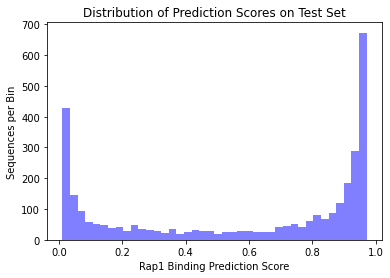

In [1279]:
#plot the distribution of scores
num_bins = 40
n, bins, patches = plt.hist(test_scores, num_bins, facecolor = 'blue', alpha = 0.5)
plt.xlabel('Rap1 Binding Prediction Score')
plt.ylabel('Sequences per Bin')
plt.title('Distribution of Prediction Scores on Test Set')
plt.show()

This trimmed down model does actually quite well. This distribution is definitely bi-modal and the score tend to be very close to 0 or 1. I am curious if the smatter of scores in the middle represent truly ambiguous sequences or if there is some failing of this model. I guess time will tell.